In this section you need to perform regression of the following two variables:
-   *s_bytes_all*. It represents the number of bytes from server to client transmitted in
    the payload, including retransmissions. It is measured in bytes.
    Note: in order to predict this feature you cannot use the following column:
        - s_bytes_uniq
-   *s_rtt_avg*. It represents the average RTT from server to client computed measuring
    the time elapsed between the data segment and the corresponding ACK. It is
    measured in milliseconds (ms). Remove values equal to 0.
    Note: in order to predict this feature you cannot use the columns related to other
    measures of RTT

### s_bytes_all

#### Data Processing

In [1]:
# import needed python libraries

%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import numpy.ma as ma #masked_array for recovering GridSearch results
import random
import math
import copy


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

In [2]:
# working datasets

features_dict = {} #feature dictionary --> feature : description
with open("readme.txt", 'r') as f:
    for i, line in enumerate(f.readlines()):
        if (i >= 2):
            kv = line.split(':')
            features_dict[kv[0].strip()] = kv[1].strip()
            
features_list = list(features_dict.keys())

In [3]:
df_training = pd.read_csv("https_training.csv")

df_train_copy = df_training.drop(columns = ["label", "c_ip", "time"
                                            , "_s_bytes_uniq"
                                           ])
mask = df_train_copy["_s_rtt_avg"]!=0
df_train_copy = df_train_copy[mask]
df_train_copy

,_c_ack_cnt,_c_ack_cnt_p,_c_appdataB,_c_appdataT,_c_bytes_all,_c_bytes_retx,_c_bytes_uniq,_c_cwin_ini,_c_cwin_max,_c_cwin_min,...,_s_syn_cnt,_s_syn_retx,_s_tm_opt,_s_ttl_max,_s_ttl_min,_s_win_0,_s_win_max,_s_win_min,_s_win_scl,_tls_session_stat
0,8.0,4.0,569.0,522.003,1672.0,0.0,1672.0,517.0,590.0,51.0,...,1.0,0.0,1.0,59.0,59.0,0.0,31232.0,27680.0,9.0,1.0
1,10.0,7.0,275.0,39.504,636.0,0.0,636.0,181.0,362.0,1.0,...,1.0,0.0,1.0,59.0,59.0,0.0,29480.0,27680.0,0.0,0.0
2,7.0,3.0,569.0,110.003,3325.0,0.0,3325.0,517.0,1435.0,51.0,...,1.0,0.0,1.0,59.0,59.0,0.0,34304.0,27680.0,9.0,1.0
3,8.0,3.0,453.0,8.813,958.0,0.0,958.0,401.0,557.0,1.0,...,1.0,0.0,0.0,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0
4,6.0,2.0,0.0,0.000,452.0,0.0,452.0,401.0,401.0,1.0,...,1.0,0.0,0.0,59.0,59.0,0.0,29184.0,27920.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147858,8.0,3.0,453.0,10.011,907.0,0.0,907.0,401.0,506.0,51.0,...,1.0,0.0,0.0,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0
147859,12.0,4.0,446.0,16.000,2068.0,0.0,2068.0,394.0,838.0,51.0,...,1.0,0.0,0.0,59.0,59.0,0.0,33792.0,27920.0,9.0,0.0
147860,12.0,6.0,306.0,53.987,430.0,0.0,430.0,212.0,212.0,38.0,...,1.0,0.0,0.0,59.0,59.0,0.0,29184.0,27920.0,9.0,0.0
147861,13.0,6.0,306.0,54.000,886.0,0.0,886.0,212.0,543.0,38.0,...,1.0,0.0,0.0,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0


In [4]:
df_test = pd.read_csv("https_test.csv")

df_test_copy = df_test.drop(columns = ["label", "c_ip", "time"
                                       , "_s_bytes_uniq"
                                      ])
mask = df_test_copy["_s_rtt_avg"]!=0
df_test_copy = df_test_copy[mask]
df_test_copy

,_c_ack_cnt,_c_ack_cnt_p,_c_appdataB,_c_appdataT,_c_bytes_all,_c_bytes_retx,_c_bytes_uniq,_c_cwin_ini,_c_cwin_max,_c_cwin_min,...,_s_syn_cnt,_s_syn_retx,_s_tm_opt,_s_ttl_max,_s_ttl_min,_s_win_0,_s_win_max,_s_win_min,_s_win_scl,_tls_session_stat
0,24.0,5.0,309.0,11.673,725.0,13.0,712.0,215.0,459.0,1.0,...,1.0,0.0,0.0,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0
1,10.0,6.0,409.0,47.964,671.0,0.0,671.0,282.0,282.0,126.0,...,1.0,0.0,1.0,59.0,59.0,0.0,30208.0,27680.0,9.0,0.0
2,10.0,6.0,410.0,36.464,729.0,0.0,729.0,283.0,320.0,1.0,...,1.0,0.0,1.0,59.0,59.0,0.0,30208.0,27680.0,9.0,0.0
3,12.0,7.0,341.0,14.198,540.0,0.0,540.0,247.0,262.0,31.0,...,1.0,0.0,1.0,59.0,59.0,0.0,30208.0,27680.0,9.0,1.0
4,25.0,6.0,309.0,20.617,725.0,13.0,712.0,215.0,459.0,38.0,...,1.0,0.0,0.0,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114575,27.0,7.0,611.0,16.013,2965.0,13.0,2952.0,517.0,2397.0,38.0,...,1.0,0.0,0.0,59.0,59.0,0.0,34816.0,27920.0,9.0,1.0
114576,13.0,2.0,569.0,10.008,1425.0,6.0,1419.0,517.0,902.0,51.0,...,1.0,0.0,0.0,59.0,59.0,0.0,30720.0,27920.0,9.0,1.0
114577,7.0,3.0,611.0,24.000,997.0,0.0,997.0,517.0,517.0,93.0,...,1.0,0.0,1.0,59.0,59.0,0.0,30208.0,27680.0,9.0,1.0
114578,7.0,3.0,0.0,0.000,610.0,0.0,610.0,517.0,517.0,93.0,...,1.0,0.0,0.0,59.0,59.0,0.0,29184.0,27920.0,9.0,1.0


In [5]:
features_list_copy = features_list.copy()
features_list_copy.remove("_s_bytes_all")
features_list_copy.remove("_s_bytes_uniq")
features_list_copy = features_list_copy[:-3]

In [6]:
### Data Preprocessing - ELIMINATION OF HIGHLY CORRELATED FEATURES!!!

X = df_train_copy.drop(columns = "_s_bytes_all").to_numpy()
y = df_train_copy["_s_bytes_all"].to_numpy()

X_test = df_test_copy.drop(columns = "_s_bytes_all").to_numpy()
y_test = df_test_copy["_s_bytes_all"].to_numpy()

# splitting training set 
X, X_val, y, y_val = train_test_split( # X -> features, y -> labels
    X, # X
    y, # y
    #stratify = df_training['numerical_label'], # no need of stratification
    train_size = 0.7, # percentage of training set
    random_state = 15 
)

# Standardize data
scaler = StandardScaler()
scaler.fit(X)



X_s = pd.DataFrame(scaler.transform(X), columns = features_list_copy)
X_val_s = pd.DataFrame(scaler.transform(X_val), columns = features_list_copy)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns = features_list_copy)


correlation_matrix = X_s.corr().abs()

def correlated_features_to_remove(correlation_matrix):
    to_delete = []
    for i, f1 in enumerate(correlation_matrix):
        for j, f2 in enumerate(correlation_matrix) :
            if (i!=j and correlation_matrix.iloc[i, j]>0.8 and (f2 not in to_delete)):
                to_delete.append(f1)
                break
    return to_delete

to_delete = correlated_features_to_remove(correlation_matrix)

print(len(to_delete), 'features are removed')

#X_s.drop(columns = to_delete, inplace = True)
#X_val_s.drop(columns = to_delete, inplace = True)
#X_test_s.drop(columns = to_delete, inplace = True)

44 features are removed


1. Choose at least 3 ML methods, and perform the model training, with default
parameter configuration, evaluating the performance on both training and test set.
Output the regression metrics results. Do you observe overfitting or under-fitting? 

In [8]:
%%time
# Refer to LASSO regressor 
# by training scikit-learn models with default configuration.

#fit the models
lasso_regressor = Lasso()

lasso_regressor.fit(X_s, y)

#predictions on training and test sets
predictions_train = lasso_regressor.predict(X_s)
predictions_val = lasso_regressor.predict(X_val_s)
predictions_test = lasso_regressor.predict(X_test_s)

CPU times: user 2min 57s, sys: 5min 11s, total: 8min 8s
Wall time: 1min 1s


In [9]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error

### --- mean_squared_error --- ###
MSE_lassoRegression_train = mean_squared_error(predictions_train, y)
MSE_lassoRegression_val = mean_squared_error(predictions_val, y_val)
MSE_lassoRegression_test = mean_squared_error(predictions_test, y_test)


### --- mealasso_regressorlute_error --- ###
MAE_lassoRegression_train = mean_absolute_error(predictions_train, y)
MAE_lassoRegression_val = mean_absolute_error(predictions_val, y_val)
MAE_lassoRegression_test = mean_absolute_error(predictions_test, y_test)


### --- print the results --- ###
print("LASSO REGRESSOR EVALUATION:")
print("\tTRAIN SET")
#print("\t\tMEAN SQUARED ERROR = %.2f" %(MSE_lassoRegression_train))
print("\t\tMEAN ABSOLUTE ERROR = %.2f kB" %(MAE_lassoRegression_train/1000))
print("\tVAL SET")
#print("\t\tMEAN SQUARED ERROR = %.2f" %(MSE_lassoRegression_test))
print("\t\tMEAN ABSOLUTE ERROR = %.2f kB" %(MAE_lassoRegression_val/1000))
print("\tTEST SET")
#print("\t\tMEAN SQUARED ERROR = %.2f" %(MSE_lassoRegression_test))
print("\t\tMEAN ABSOLUTE ERROR = %.2f kB" %(MAE_lassoRegression_test/1000))


LASSO REGRESSOR EVALUATION:
	TRAIN SET
		MEAN ABSOLUTE ERROR = 7.66 kB
	VAL SET
		MEAN ABSOLUTE ERROR = 7.88 kB
	TEST SET
		MEAN ABSOLUTE ERROR = 8.79 kB


#### Previous result by eliminating high correlated features
LASSO REGRESSOR EVALUATION:
	TRAIN SET
		MEAN SQUARED ERROR = 2175585514.97
		MEAN ABSOLUTE ERROR = 9245.74
	TEST SET
		MEAN SQUARED ERROR = 3279445432.86
		MEAN ABSOLUTE ERROR = 9641.18

#### Result without eliminating high correlated features
LASSO REGRESSOR EVALUATION:
	TRAIN SET
		MEAN SQUARED ERROR = 1317977400.68
		MEAN ABSOLUTE ERROR = 7295.74
	TEST SET
		MEAN SQUARED ERROR = 2321250249.30
		MEAN ABSOLUTE ERROR = 7953.85
        
#### Result without eliminating _s_bytes_uniq
LASSO REGRESSOR EVALUATION:
	TRAIN SET
		MEAN SQUARED ERROR = 1247356948.92
		MEAN ABSOLUTE ERROR = 7145.32
	TEST SET
		MEAN SQUARED ERROR = 2187575348.01
		MEAN ABSOLUTE ERROR = 7788.87


## Validation Curve

In [18]:
%%time
alpha_range = [0.001, 0.01, 0.1, 1, 10, 100] #13.29
# Create the Lasso; 
ls_regressor = Lasso()

# Generate validation curve using Mean Squared Error (MSE) as the scoring metric
train_scores, val_scores = validation_curve(
    ls_regressor, X, y, param_name="alpha", param_range=alpha_range,
    scoring="neg_mean_absolute_error", cv=5
)


CPU times: user 2h 21min 13s, sys: 3h 56min 54s, total: 6h 18min 7s
Wall time: 47min 27s


In [19]:
train_scores
#array of n arrays for each n_estimator of 5 accuracy values for each split

array([[-7874.52281984, -6360.80889367, -7701.70996598, -7097.6138297 ,
        -7402.36577573],
       [-7875.04197877, -6360.789016  , -7701.3177967 , -7098.05391204,
        -7402.74691145],
       [-7880.37052854, -6361.45460715, -7697.70629336, -7102.77532923,
        -7405.50705644],
       [-7919.73252915, -6365.63353054, -7693.25219279, -7130.78027241,
        -7457.4722193 ],
       [-7833.26483429, -6396.92364235, -7871.08356597, -7102.97288719,
        -7434.71464691],
       [-7847.03173435, -6282.73950793, -7696.9814885 , -7053.02697312,
        -7400.67144275]])

In [20]:
val_scores
#array of n arrays for each n_estimator of 5 accuracy values for each split

array([[-8269.29302203, -6769.04455663, -7777.53677893, -7637.76343433,
        -7833.75783139],
       [-8269.81401628, -6769.0255815 , -7776.96137031, -7637.95125022,
        -7834.04108593],
       [-8275.13152449, -6769.39978819, -7771.47439064, -7640.23367781,
        -7835.98847116],
       [-8314.35555987, -6772.6729264 , -7760.96968551, -7656.9435055 ,
        -7883.99399374],
       [-8230.2750779 , -6811.45144193, -8021.40114186, -7663.12379624,
        -7864.20988807],
       [-8220.93529016, -6669.63465877, -7787.31451938, -7634.54782883,
        -7751.52887384]])

In [10]:
##recovering previous results

alpha_range = [0.001, 0.01, 0.1, 1, 10, 100]


train_scores = np.array([[-7874.52281984, -6360.80889367, -7701.70996598, -7097.6138297 ,
        -7402.36577573],
       [-7875.04197877, -6360.789016  , -7701.3177967 , -7098.05391204,
        -7402.74691145],
       [-7880.37052854, -6361.45460715, -7697.70629336, -7102.77532923,
        -7405.50705644],
       [-7919.73252915, -6365.63353054, -7693.25219279, -7130.78027241,
        -7457.4722193 ],
       [-7833.26483429, -6396.92364235, -7871.08356597, -7102.97288719,
        -7434.71464691],
       [-7847.03173435, -6282.73950793, -7696.9814885 , -7053.02697312,
        -7400.67144275]])

val_scores = np.array([[-8269.29302203, -6769.04455663, -7777.53677893, -7637.76343433,
        -7833.75783139],
       [-8269.81401628, -6769.0255815 , -7776.96137031, -7637.95125022,
        -7834.04108593],
       [-8275.13152449, -6769.39978819, -7771.47439064, -7640.23367781,
        -7835.98847116],
       [-8314.35555987, -6772.6729264 , -7760.96968551, -7656.9435055 ,
        -7883.99399374],
       [-8230.2750779 , -6811.45144193, -8021.40114186, -7663.12379624,
        -7864.20988807],
       [-8220.93529016, -6669.63465877, -7787.31451938, -7634.54782883,
        -7751.52887384]])

In [11]:
info_mse_train = []
info_mse_val = []
best_val_score = -val_scores[0].mean()
best_parameter = -1

for n, param in enumerate(alpha_range):
    #test_scores
    mse_mean_train = -train_scores[n].mean()/1000
    mse_min_train = -train_scores[n].min()/1000
    mse_max_train = -train_scores[n].max()/1000
    info_mse_train.append((mse_mean_train, mse_min_train, mse_max_train))
    #val_scores
    mse_mean_val = -val_scores[n].mean()/1000
    mse_min_val = -val_scores[n].min()/1000
    mse_max_val = -val_scores[n].max()/1000
    if (mse_mean_val<best_val_score):
        best_val_score = mse_mean_val
        best_parameter = param
    info_mse_val.append((mse_mean_val, mse_min_val, mse_max_val))


info_mse_val
   



[(7.657479124662001, 8.26929302203, 6.769044556630001),
 (7.657558660848001, 8.26981401628, 6.7690255815),
 (7.658445570458, 8.27513152449, 6.76939978819),
 (7.677787134203999, 8.31435555987, 6.772672926399999),
 (7.7180922692, 8.2302750779, 6.81145144193),
 (7.612792234196, 8.22093529016, 6.66963465877)]

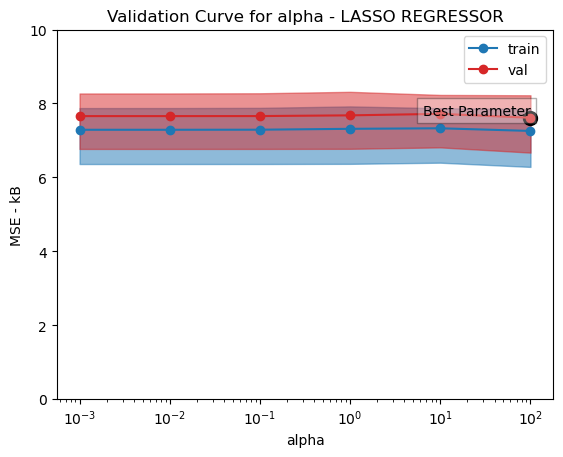

In [12]:
plt.figure()
x =  alpha_range
plt.plot(x, [info_mse_train[i][0] for i in range(len(x))],'-o', color='tab:blue', label='train')
plt.fill_between(
    x, 
    [info_mse_train[i][1] for i in range(len(x))], 
    [info_mse_train[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:blue'
)
plt.plot(x, [info_mse_val[i][0] for i in range(len(x))],'-o', color='tab:red', label='val')
plt.fill_between(
    x, 
    [info_mse_val[i][1] for i in range(len(x))], 
    [info_mse_val[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:red'
)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE - kB')
plt.title('Validation Curve for alpha - LASSO REGRESSOR')
plt.ylim(0, 10)
plt.scatter(best_parameter, best_val_score, marker='o', color='black',s=100)
plt.text(best_parameter, best_val_score, "Best Parameter", color='black', ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.3))
#plt.xticks(x, alpha_range)
plt.legend()
plt.show()

In [13]:
best_val_score

7.612792234196

In [13]:
best_parameter

100

In [23]:
%%time
alpha_range = np.logspace(2, 7, 7)
 #13.29
# Create the Lasso; 
ls_regressor = Lasso()

# Generate validation curve using Mean Squared Error (MSE) as the scoring metric
train_scores, val_scores = validation_curve(
    ls_regressor, X, y, param_name="alpha", param_range=alpha_range,
    scoring="neg_mean_absolute_error", cv=5
)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.030e+14, tolerance: 1.469e+14
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.527e+14, tolerance: 1.469e+14
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

CPU times: user 2h 26min 45s, sys: 3h 54min 10s, total: 6h 20min 56s
Wall time: 47min 50s


In [30]:
train_scores
#array of n arrays for each n_estimator of 5 accuracy values for each split

array([[ -6973.33058463,  -7422.1470394 ,  -6579.72067152,
         -6670.63561847,  -6865.44185814],
       [ -6809.37189159,  -7162.64729053,  -6495.2647726 ,
         -6643.13392569,  -6741.81265314],
       [ -6737.102183  ,  -7178.39896167,  -6465.69113881,
         -6585.4120372 ,  -6732.57202395],
       [ -6881.40430958,  -7270.58099014,  -6572.91153738,
         -6777.67706863,  -6681.55019121],
       [ -7715.53990108,  -8011.13391194,  -7512.84003888,
         -7238.47428334,  -7007.58166638],
       [ -9053.16191625,  -9335.26771812,  -8743.02649523,
         -8683.95980056,  -8067.24610402],
       [-15391.46324903, -14574.37912983, -14353.58629924,
        -15804.2884662 , -10440.7693266 ]])

In [31]:
val_scores
#array of n arrays for each n_estimator of 5 accuracy values for each split

array([[ -7184.52791402,  -7257.96022231,  -7373.59271412,
         -7325.23217129,  -6559.40941339],
       [ -6936.85508324,  -6911.53101374,  -7209.33499651,
         -7287.26292097,  -6424.3810475 ],
       [ -6751.98538072,  -6896.96505165,  -7078.71949035,
         -7222.76740392,  -6401.52109249],
       [ -6850.65245641,  -6936.64474875,  -7258.82434374,
         -7384.72379426,  -6360.06989969],
       [ -7623.07511969,  -7762.66177307,  -8257.24854126,
         -7611.6765415 ,  -6906.50487719],
       [ -8932.05012521,  -9145.3085397 ,  -9600.6234952 ,
         -8939.70666545,  -8182.19807101],
       [-14746.29598817, -14331.51774802, -15881.99170556,
        -15807.24660549, -11145.11807806]])

In [24]:
##recovering previous results

alpha_range = np.logspace(2, 7, 7)


train_scores = np.array([[ -6973.33058463,  -7422.1470394 ,  -6579.72067152,
         -6670.63561847,  -6865.44185814],
       [ -6809.37189159,  -7162.64729053,  -6495.2647726 ,
         -6643.13392569,  -6741.81265314],
       [ -6737.102183  ,  -7178.39896167,  -6465.69113881,
         -6585.4120372 ,  -6732.57202395],
       [ -6881.40430958,  -7270.58099014,  -6572.91153738,
         -6777.67706863,  -6681.55019121],
       [ -7715.53990108,  -8011.13391194,  -7512.84003888,
         -7238.47428334,  -7007.58166638],
       [ -9053.16191625,  -9335.26771812,  -8743.02649523,
         -8683.95980056,  -8067.24610402],
       [-15391.46324903, -14574.37912983, -14353.58629924,
        -15804.2884662 , -10440.7693266 ]])

val_scores = np.array([[ -7184.52791402,  -7257.96022231,  -7373.59271412,
         -7325.23217129,  -6559.40941339],
       [ -6936.85508324,  -6911.53101374,  -7209.33499651,
         -7287.26292097,  -6424.3810475 ],
       [ -6751.98538072,  -6896.96505165,  -7078.71949035,
         -7222.76740392,  -6401.52109249],
       [ -6850.65245641,  -6936.64474875,  -7258.82434374,
         -7384.72379426,  -6360.06989969],
       [ -7623.07511969,  -7762.66177307,  -8257.24854126,
         -7611.6765415 ,  -6906.50487719],
       [ -8932.05012521,  -9145.3085397 ,  -9600.6234952 ,
         -8939.70666545,  -8182.19807101],
       [-14746.29598817, -14331.51774802, -15881.99170556,
        -15807.24660549, -11145.11807806]])

In [25]:
info_mse_train = []
info_mse_val = []
best_val_score = -val_scores[0].mean()
best_parameter = -1

for n, param in enumerate(alpha_range):
    #test_scores
    mse_mean_train = -train_scores[n].mean()/1000
    mse_min_train = -train_scores[n].min()/1000
    mse_max_train = -train_scores[n].max()/1000
    info_mse_train.append((mse_mean_train, mse_min_train, mse_max_train))
    #val_scores
    mse_mean_val = -val_scores[n].mean()/1000
    mse_min_val = -val_scores[n].min()/1000
    mse_max_val = -val_scores[n].max()/1000
    if (mse_mean_val<best_val_score):
        best_val_score = mse_mean_val
        best_parameter = param
    info_mse_val.append((mse_mean_val, mse_min_val, mse_max_val))


info_mse_val
   



[(7.140144487026, 7.37359271412, 6.55940941339),
 (6.953873012392, 7.28726292097, 6.4243810475),
 (6.870391683826, 7.22276740392, 6.40152109249),
 (6.9581830485700005, 7.38472379426, 6.36006989969),
 (7.632233370542, 8.25724854126, 6.90650487719),
 (8.959977379314, 9.600623495199999, 8.18219807101),
 (14.382434025060002, 15.881991705559999, 11.145118078060001)]

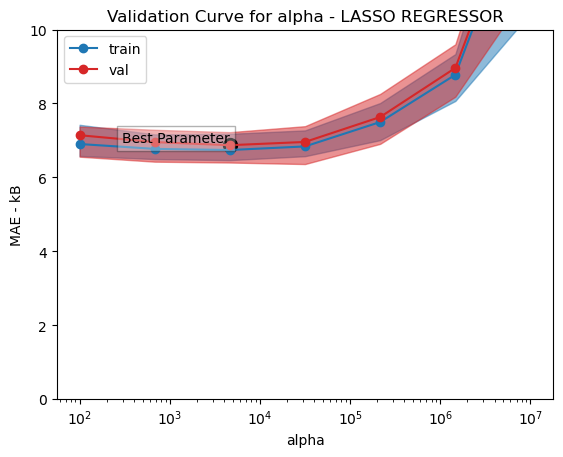

In [26]:
plt.figure()
x =  alpha_range
plt.plot(x, [info_mse_train[i][0] for i in range(len(x))],'-o', color='tab:blue', label='train')
plt.fill_between(
    x, 
    [info_mse_train[i][1] for i in range(len(x))], 
    [info_mse_train[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:blue'
)
plt.plot(x, [info_mse_val[i][0] for i in range(len(x))],'-o', color='tab:red', label='val')
plt.fill_between(
    x, 
    [info_mse_val[i][1] for i in range(len(x))], 
    [info_mse_val[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:red'
)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE - kB')
plt.title('Validation Curve for alpha - LASSO REGRESSOR')
plt.ylim(0, 10)
plt.scatter(best_parameter, best_val_score, marker='o', color='black',s=100)
plt.text(best_parameter, best_val_score, "Best Parameter", color='black', ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.3))
#plt.xticks(x, alpha_range)
plt.legend()
plt.show()

In [27]:
best_val_score

6.870391683826

In [28]:
best_parameter

4641.588833612782

In [7]:
%%time
alpha_range = np.logspace(7, 15, 9)
 #13.29
# Create the Lasso; 
ls_regressor = Lasso()

# Generate validation curve using Mean Squared Error (MSE) as the scoring metric
train_scores, val_scores = validation_curve(
    ls_regressor, X, y, param_name="alpha", param_range=alpha_range,
    scoring="neg_mean_absolute_error", cv=5
)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.029e+14, tolerance: 1.514e+14
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e+15, tolerance: 1.514e+14
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

CPU times: user 36min 56s, sys: 59min 59s, total: 1h 36min 55s
Wall time: 12min 15s


In [8]:
train_scores
#array of n arrays for each n_estimator of 5 accuracy values for each split

array([[ -15391.46324903,  -14574.37912983,  -14353.58629924,
         -15804.2884662 ,  -10440.7693266 ],
       [ -14029.3148045 ,  -15797.26125028,  -13872.48797252,
         -14448.33990525,  -14230.64949314],
       [ -74862.20470074,  -93588.46411123,  -77775.65424292,
         -79237.76842566,  -80835.65338856],
       [-690955.26811241, -604025.85150416, -677589.63449214,
        -652225.07074323, -715000.18255554],
       [-438773.54635247, -431317.0355724 , -426081.11288514,
        -418184.86546269, -437589.97261431],
       [-603545.68786139, -583659.78143403, -596200.96593783,
        -581415.84909537, -610015.25996675],
       [-603545.68786139, -583659.78143403, -596200.96593783,
        -581415.84909537, -610015.25996675],
       [-603545.68786139, -583659.78143403, -596200.96593783,
        -581415.84909537, -610015.25996675],
       [-603545.68786139, -583659.78143403, -596200.96593783,
        -581415.84909537, -610015.25996675]])

In [9]:
val_scores
#array of n arrays for each n_estimator of 5 accuracy values for each split

array([[ -14746.29598817,  -14331.51774802,  -15881.99170556,
         -15807.24660549,  -11145.11807806],
       [ -12874.20945793,  -16295.71564074,  -14824.11164773,
         -14716.8231964 ,  -14677.27819223],
       [ -71250.71755498, -100703.88606078,  -77134.88275149,
         -83621.51831447,  -77536.13252251],
       [-659611.98804676, -652766.04341035, -668348.79218556,
        -695752.60099918, -673593.76330754],
       [-413787.04389362, -471382.957374  , -419653.24063573,
        -455049.89219706, -392514.354956  ],
       [-579517.07877962, -615779.21099244, -592251.77781517,
        -616874.82432501, -570464.4594796 ],
       [-579517.07877962, -615779.21099244, -592251.77781517,
        -616874.82432501, -570464.4594796 ],
       [-579517.07877962, -615779.21099244, -592251.77781517,
        -616874.82432501, -570464.4594796 ],
       [-579517.07877962, -615779.21099244, -592251.77781517,
        -616874.82432501, -570464.4594796 ]])

In [36]:
##recovering previous results

alpha_range = np.logspace(7, 15, 9)


train_scores = np.array([[ -15391.46324903,  -14574.37912983,  -14353.58629924,
         -15804.2884662 ,  -10440.7693266 ],
       [ -14029.3148045 ,  -15797.26125028,  -13872.48797252,
         -14448.33990525,  -14230.64949314],
       [ -74862.20470074,  -93588.46411123,  -77775.65424292,
         -79237.76842566,  -80835.65338856],
       [-690955.26811241, -604025.85150416, -677589.63449214,
        -652225.07074323, -715000.18255554],
       [-438773.54635247, -431317.0355724 , -426081.11288514,
        -418184.86546269, -437589.97261431],
       [-603545.68786139, -583659.78143403, -596200.96593783,
        -581415.84909537, -610015.25996675],
       [-603545.68786139, -583659.78143403, -596200.96593783,
        -581415.84909537, -610015.25996675],
       [-603545.68786139, -583659.78143403, -596200.96593783,
        -581415.84909537, -610015.25996675],
       [-603545.68786139, -583659.78143403, -596200.96593783,
        -581415.84909537, -610015.25996675]])

val_scores = np.array([[ -14746.29598817,  -14331.51774802,  -15881.99170556,
         -15807.24660549,  -11145.11807806],
       [ -12874.20945793,  -16295.71564074,  -14824.11164773,
         -14716.8231964 ,  -14677.27819223],
       [ -71250.71755498, -100703.88606078,  -77134.88275149,
         -83621.51831447,  -77536.13252251],
       [-659611.98804676, -652766.04341035, -668348.79218556,
        -695752.60099918, -673593.76330754],
       [-413787.04389362, -471382.957374  , -419653.24063573,
        -455049.89219706, -392514.354956  ],
       [-579517.07877962, -615779.21099244, -592251.77781517,
        -616874.82432501, -570464.4594796 ],
       [-579517.07877962, -615779.21099244, -592251.77781517,
        -616874.82432501, -570464.4594796 ],
       [-579517.07877962, -615779.21099244, -592251.77781517,
        -616874.82432501, -570464.4594796 ],
       [-579517.07877962, -615779.21099244, -592251.77781517,
        -616874.82432501, -570464.4594796 ]])

In [37]:
info_mse_train = []
info_mse_val = []
best_val_score = -val_scores[0].mean()
best_parameter = -1

for n, param in enumerate(alpha_range):
    #test_scores
    mse_mean_train = -train_scores[n].mean()/1000
    mse_min_train = -train_scores[n].min()/1000
    mse_max_train = -train_scores[n].max()/1000
    info_mse_train.append((mse_mean_train, mse_min_train, mse_max_train))
    #val_scores
    mse_mean_val = -val_scores[n].mean()/1000
    mse_min_val = -val_scores[n].min()/1000
    mse_max_val = -val_scores[n].max()/1000
    if (mse_mean_val<best_val_score):
        best_val_score = mse_mean_val
        best_parameter = param
    info_mse_val.append((mse_mean_val, mse_min_val, mse_max_val))


info_mse_val
   



[(14.382434025060002, 15.881991705559999, 11.145118078060001),
 (14.677627627006, 16.29571564074, 12.874209457929998),
 (82.049427440846, 100.70388606078001, 71.25071755498),
 (670.0146375898778, 695.75260099918, 652.76604341035),
 (430.4774978112819, 471.382957374, 392.514354956),
 (594.977470278368, 616.87482432501, 570.4644594796),
 (594.977470278368, 616.87482432501, 570.4644594796),
 (594.977470278368, 616.87482432501, 570.4644594796),
 (594.977470278368, 616.87482432501, 570.4644594796)]

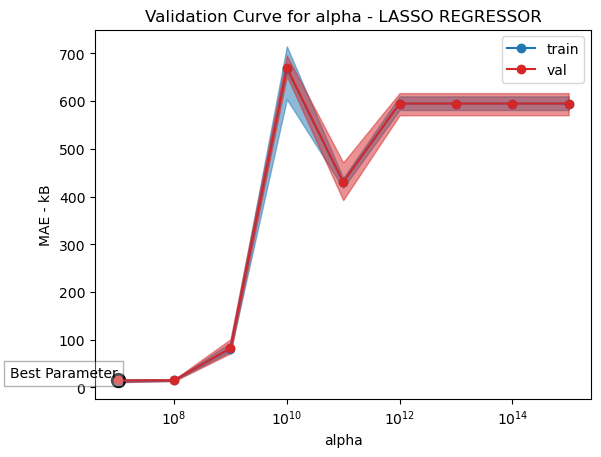

In [38]:
plt.figure()
x =  alpha_range
plt.plot(x, [info_mse_train[i][0] for i in range(len(x))],'-o', color='tab:blue', label='train')
plt.fill_between(
    x, 
    [info_mse_train[i][1] for i in range(len(x))], 
    [info_mse_train[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:blue'
)
plt.plot(x, [info_mse_val[i][0] for i in range(len(x))],'-o', color='tab:red', label='val')
plt.fill_between(
    x, 
    [info_mse_val[i][1] for i in range(len(x))], 
    [info_mse_val[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:red'
)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE - kB')
plt.title('Validation Curve for alpha - LASSO REGRESSOR')
#plt.ylim(0, 10)
plt.scatter(best_parameter, best_val_score, marker='o', color='black',s=100)
plt.text(best_parameter, best_val_score, "Best Parameter", color='black', ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.3))
#plt.xticks(x, alpha_range)
plt.legend()
plt.show()

In [39]:
best_val_score

14.382434025060002

#### LEARNING CURVE

In [21]:
### Now we need to use the entire training dataset for learning curve 
X = df_train_copy.drop(columns = "_s_bytes_all").to_numpy()
y = df_train_copy["_s_bytes_all"].to_numpy()

# Standardize data
scaler = StandardScaler()
scaler.fit(X)

# X --> X_learningCurve_s
X_learningCurve_s = pd.DataFrame(scaler.transform(X), columns = features_list_copy)

In [22]:
%%time
# Create the RandomForestClassifier with best combination's parameters previously found
ls = Lasso(
    ####---best parameters---###
    alpha = best_parameter
)

train_sizes, train_scores, val_scores = learning_curve(
    ls, X_learningCurve_s, y, cv=KFold(n_splits=5, shuffle=True, random_state=42),
    train_sizes=np.arange(0.1, 1.0, 0.1), scoring="neg_mean_absolute_error"
)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


CPU times: user 8min 58s, sys: 14min 39s, total: 23min 38s
Wall time: 3min 5s


In [23]:
train_sizes

array([ 11829,  23658,  35487,  47316,  59145,  70974,  82803,  94632,
       106461])

In [24]:
train_scores

array([[-8952.99738013, -8753.43162169, -8974.53586056, -8850.8702229 ,
        -9175.50749329],
       [-7239.84700296, -5265.60197478, -5776.22597427, -6021.11754292,
        -5755.62544606],
       [-6412.5840697 , -6659.94628807, -6478.51242844, -6503.07789634,
        -6226.78046426],
       [-6813.92504188, -7344.1685677 , -7569.24049269, -7256.56014089,
        -7201.58480963],
       [-5190.58357228, -5849.53886221, -6022.23173098, -6006.40013204,
        -6762.35445723],
       [-5293.11978184, -5757.88566578, -5871.32433052, -5852.58019593,
        -6725.00928373],
       [-5265.83446402, -5360.12961121, -5508.39963048, -5445.2943346 ,
        -6239.60076893],
       [-5229.39014367, -5290.95337709, -5607.43236753, -5416.22623293,
        -6189.18273417],
       [-5486.74122838, -5197.33487258, -5883.59038663, -5904.07348192,
        -5996.14482255]])

In [25]:
val_scores

array([[-14048.14263298, -14601.10838568, -12912.51580626,
        -14726.88681642, -13425.67408755],
       [ -9894.85142441,  -7652.78730119,  -7287.9247933 ,
         -8509.78369339,  -7066.41530572],
       [ -7801.3911239 ,  -8636.6939234 ,  -7636.79761644,
         -8191.202241  ,  -6871.03014467],
       [ -7610.13955677,  -8885.01071466,  -8444.97799617,
         -8462.83195448,  -7506.58636478],
       [ -5558.9595195 ,  -6942.33421878,  -6563.29634795,
         -6623.89889173,  -6979.8916753 ],
       [ -5551.96639114,  -6669.36862556,  -6102.8531714 ,
         -6256.98979698,  -6753.72859134],
       [ -5561.44278079,  -6130.84308531,  -5647.01235631,
         -5772.94754453,  -6101.96034509],
       [ -5548.11575107,  -6002.7659038 ,  -5724.48514068,
         -5727.11458384,  -6019.20658751],
       [ -6112.99688327,  -5952.18762185,  -5941.00370335,
         -5903.1025999 ,  -5624.54971774]])

In [20]:
### recovering previous results
train_sizes = np.array([ 11829,  23658,  35487,  47316,  59145,  70974,  82803,  94632,
       106461])

train_scores = np.array([[-8952.99738013, -8753.43162169, -8974.53586056, -8850.8702229 ,
        -9175.50749329],
       [-7239.84700296, -5265.60197478, -5776.22597427, -6021.11754292,
        -5755.62544606],
       [-6412.5840697 , -6659.94628807, -6478.51242844, -6503.07789634,
        -6226.78046426],
       [-6813.92504188, -7344.1685677 , -7569.24049269, -7256.56014089,
        -7201.58480963],
       [-5190.58357228, -5849.53886221, -6022.23173098, -6006.40013204,
        -6762.35445723],
       [-5293.11978184, -5757.88566578, -5871.32433052, -5852.58019593,
        -6725.00928373],
       [-5265.83446402, -5360.12961121, -5508.39963048, -5445.2943346 ,
        -6239.60076893],
       [-5229.39014367, -5290.95337709, -5607.43236753, -5416.22623293,
        -6189.18273417],
       [-5486.74122838, -5197.33487258, -5883.59038663, -5904.07348192,
        -5996.14482255]])

val_scores = np.array([[-14048.14263298, -14601.10838568, -12912.51580626,
        -14726.88681642, -13425.67408755],
       [ -9894.85142441,  -7652.78730119,  -7287.9247933 ,
         -8509.78369339,  -7066.41530572],
       [ -7801.3911239 ,  -8636.6939234 ,  -7636.79761644,
         -8191.202241  ,  -6871.03014467],
       [ -7610.13955677,  -8885.01071466,  -8444.97799617,
         -8462.83195448,  -7506.58636478],
       [ -5558.9595195 ,  -6942.33421878,  -6563.29634795,
         -6623.89889173,  -6979.8916753 ],
       [ -5551.96639114,  -6669.36862556,  -6102.8531714 ,
         -6256.98979698,  -6753.72859134],
       [ -5561.44278079,  -6130.84308531,  -5647.01235631,
         -5772.94754453,  -6101.96034509],
       [ -5548.11575107,  -6002.7659038 ,  -5724.48514068,
         -5727.11458384,  -6019.20658751],
       [ -6112.99688327,  -5952.18762185,  -5941.00370335,
         -5903.1025999 ,  -5624.54971774]])

In [21]:
info_mae_train = []
info_mae_val = []

best_val_score = 1e20
best_proportion = 0

for n, train_proportion in enumerate(np.arange(0.1, 1.0, 0.1)): 
    #test_scores
    mae_mean_train = -train_scores[n].mean()
    mae_min_train = -train_scores[n].min()
    mae_max_train = -train_scores[n].max()
    info_mae_train.append((mae_mean_train, mae_min_train, mae_max_train))
    #val_scores
    mae_mean_val = -val_scores[n].mean()
    mae_min_val = -val_scores[n].min()
    mae_max_val = -val_scores[n].max()
    if (mae_mean_val<best_val_score):
        best_val_score = mae_mean_val
        best_proportion = train_proportion
    info_mae_val.append((mae_mean_val, mae_min_val, mae_max_val))


info_mae_val = np.array(info_mae_val)/1000
info_mae_train = np.array(info_mae_train)/1000
info_mae_val

array([[13.94286555, 14.72688682, 12.91251581],
       [ 8.0823525 ,  9.89485142,  7.06641531],
       [ 7.82742301,  8.63669392,  6.87103014],
       [ 8.18190932,  8.88501071,  7.50658636],
       [ 6.53367613,  6.97989168,  5.55895952],
       [ 6.26698132,  6.75372859,  5.55196639],
       [ 5.84284122,  6.13084309,  5.56144278],
       [ 5.80433759,  6.01920659,  5.54811575],
       [ 5.90676811,  6.11299688,  5.62454972]])

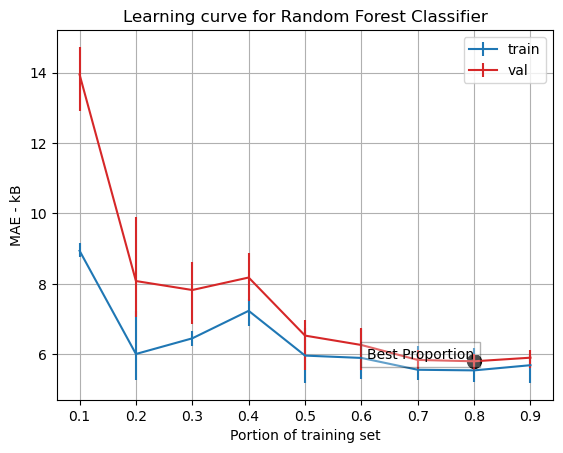

In [44]:
plt.figure()

plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info_mae_train[i][0] for i in range(len(info_mae_train))], # y-location of each error bar
    # the size of each error bar
    yerr = [
        [info_mae_train[i][0]-info_mae_train[i][1] for i in range(len(info_mae_train))], 
        [info_mae_train[i][2]-info_mae_train[i][0] for i in range(len(info_mae_train))]
    ],
    color='tab:blue',
    label='train'
)

plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info_mae_val[i][0] for i in range(len(info_mae_val))], # y-location of each error bar
    # the size of each error bar
    yerr = [
        [info_mae_val[i][0]-info_mae_val[i][1] for i in range(len(info_mae_val))], 
        [info_mae_val[i][2]-info_mae_val[i][0] for i in range(len(info_mae_val))]
    ],
    color='tab:red',
    label='val'
)
plt.grid()
plt.xlabel('Portion of training set')
plt.ylabel('MAE - kB')
plt.title("Learning curve for Random Forest Classifier")
plt.xticks(np.arange(0.1, 1.0, 0.1), labels = np.arange(0.1, 1.0, 0.1).round(1))
plt.scatter(best_proportion, best_val_score/1000, marker='o', color='black',s=100)
plt.text(best_proportion, best_val_score/1000, "Best Proportion", color='black', ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.3))
#plt.ylim(0.75, 1.02)
plt.legend()
plt.show()

# Test best model on unseen data

In [22]:
best_proportion

0.8

In [31]:
### Data Preprocessing - ELIMINATION OF HIGHLY CORRELATED FEATURES!!!

X = df_train_copy.drop(columns = "_s_bytes_all").to_numpy()
y = df_train_copy["_s_bytes_all"].to_numpy()

X_test = df_test_copy.drop(columns = "_s_bytes_all").to_numpy()
y_test = df_test_copy["_s_bytes_all"].to_numpy()

# splitting training set 
X, X_val, y, y_val = train_test_split( # X -> features, y -> labels
    X, # X
    y, # y
    #stratify = df_training['numerical_label'], # no need of stratification
    train_size = best_proportion, # percentage of training set
    random_state = 15 
)

# Standardize data
scaler = StandardScaler()
scaler.fit(X)



X_s = pd.DataFrame(scaler.transform(X), columns = features_list_copy)
X_val_s = pd.DataFrame(scaler.transform(X_val), columns = features_list_copy)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns = features_list_copy)


correlation_matrix = X_s.corr().abs()

def correlated_features_to_remove(correlation_matrix):
    to_delete = []
    for i, f1 in enumerate(correlation_matrix):
        for j, f2 in enumerate(correlation_matrix) :
            if (i!=j and correlation_matrix.iloc[i, j]>0.8 and (f2 not in to_delete)):
                to_delete.append(f1)
                break
    return to_delete

to_delete = correlated_features_to_remove(correlation_matrix)

print(len(to_delete), 'features are removed')

#X_s.drop(columns = to_delete, inplace = True)
#X_val_s.drop(columns = to_delete, inplace = True)
#X_test_s.drop(columns = to_delete, inplace = True)

45 features are removed


In [32]:
%%time
# Refer to LASSO regressor 
# by training scikit-learn models with default configuration.

#fit the models
lasso_regressor = Lasso(alpha = best_parameter)

lasso_regressor.fit(X_s, y)

#predictions on training and test sets
predictions_train = lasso_regressor.predict(X_s)
predictions_val = lasso_regressor.predict(X_val_s)
predictions_test = lasso_regressor.predict(X_test_s)

CPU times: user 1min 16s, sys: 2min 27s, total: 3min 44s
Wall time: 28.5 s


In [33]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error

### --- mean_squared_error --- ###
MSE_lassoRegression_train = mean_squared_error(predictions_train, y)
MSE_lassoRegression_val = mean_squared_error(predictions_val, y_val)
MSE_lassoRegression_test = mean_squared_error(predictions_test, y_test)


### --- mean_absolute_error --- ###
MAE_lassoRegression_train = mean_absolute_error(predictions_train, y)
MAE_lassoRegression_val = mean_absolute_error(predictions_val, y_val)
MAE_lassoRegression_test = mean_absolute_error(predictions_test, y_test)


### --- print the results --- ###
print("LASSO REGRESSOR EVALUATION:")
print("\tTRAIN SET")
#print("\t\tMEAN SQUARED ERROR = %.2f" %(MSE_lassoRegression_train))
print("\t\tMEAN ABSOLUTE ERROR = %.2f kB" %(MAE_lassoRegression_train/1000))
print("\tVAL SET")
#print("\t\tMEAN SQUARED ERROR = %.2f" %(MSE_lassoRegression_test))
print("\t\tMEAN ABSOLUTE ERROR = %.2f kB" %(MAE_lassoRegression_val/1000))
print("\tTEST SET")
#print("\t\tMEAN SQUARED ERROR = %.2f" %(MSE_lassoRegression_test))
print("\t\tMEAN ABSOLUTE ERROR = %.2f kB" %(MAE_lassoRegression_test/1000))


LASSO REGRESSOR EVALUATION:
	TRAIN SET
		MEAN ABSOLUTE ERROR = 5.97 kB
	VAL SET
		MEAN ABSOLUTE ERROR = 5.90 kB
	TEST SET
		MEAN ABSOLUTE ERROR = 5.86 kB


### s_rtt_avg

### Data Processing

In [67]:
features_list_copy = features_list.copy()

for f in features_list:
    if f[3:6]=="rtt": ### Should I remove also _c_rtt???
        features_list_copy.remove(f)
features_list_copy = features_list_copy[:-3]
#features_list_copy

In [68]:
df_train_copy = df_training.copy()[features_list_copy]
df_train_copy["_s_rtt_avg"] = df_training["_s_rtt_avg"]
mask = df_train_copy.loc[:, "_s_rtt_avg"]!=0
df_train_copy = df_train_copy[mask]
df_train_copy




    

,_c_ack_cnt,_c_ack_cnt_p,_c_appdataB,_c_appdataT,_c_bytes_all,_c_bytes_retx,_c_bytes_uniq,_c_cwin_ini,_c_cwin_max,_c_cwin_min,...,_s_syn_retx,_s_tm_opt,_s_ttl_max,_s_ttl_min,_s_win_0,_s_win_max,_s_win_min,_s_win_scl,_tls_session_stat,_s_rtt_avg
0,8.0,4.0,569.0,522.003,1672.0,0.0,1672.0,517.0,590.0,51.0,...,0.0,1.0,59.0,59.0,0.0,31232.0,27680.0,9.0,1.0,52.354922
1,10.0,7.0,275.0,39.504,636.0,0.0,636.0,181.0,362.0,1.0,...,0.0,1.0,59.0,59.0,0.0,29480.0,27680.0,0.0,0.0,0.959986
2,7.0,3.0,569.0,110.003,3325.0,0.0,3325.0,517.0,1435.0,51.0,...,0.0,1.0,59.0,59.0,0.0,34304.0,27680.0,9.0,1.0,37.272424
3,8.0,3.0,453.0,8.813,958.0,0.0,958.0,401.0,557.0,1.0,...,0.0,0.0,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0,0.309323
4,6.0,2.0,0.0,0.000,452.0,0.0,452.0,401.0,401.0,1.0,...,0.0,0.0,59.0,59.0,0.0,29184.0,27920.0,9.0,0.0,0.434978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147858,8.0,3.0,453.0,10.011,907.0,0.0,907.0,401.0,506.0,51.0,...,0.0,0.0,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0,1.289468
147859,12.0,4.0,446.0,16.000,2068.0,0.0,2068.0,394.0,838.0,51.0,...,0.0,0.0,59.0,59.0,0.0,33792.0,27920.0,9.0,0.0,3.517330
147860,12.0,6.0,306.0,53.987,430.0,0.0,430.0,212.0,212.0,38.0,...,0.0,0.0,59.0,59.0,0.0,29184.0,27920.0,9.0,0.0,2.495964
147861,13.0,6.0,306.0,54.000,886.0,0.0,886.0,212.0,543.0,38.0,...,0.0,0.0,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0,2.051685


In [69]:
df_test_copy = df_test.copy()[features_list_copy]
df_test_copy["_s_rtt_avg"] = df_test["_s_rtt_avg"]
mask = df_test_copy.loc[:, "_s_rtt_avg"]!=0
df_test_copy = df_test_copy[mask]
df_test_copy

,_c_ack_cnt,_c_ack_cnt_p,_c_appdataB,_c_appdataT,_c_bytes_all,_c_bytes_retx,_c_bytes_uniq,_c_cwin_ini,_c_cwin_max,_c_cwin_min,...,_s_syn_retx,_s_tm_opt,_s_ttl_max,_s_ttl_min,_s_win_0,_s_win_max,_s_win_min,_s_win_scl,_tls_session_stat,_s_rtt_avg
0,24.0,5.0,309.0,11.673,725.0,13.0,712.0,215.0,459.0,1.0,...,0.0,0.0,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0,14.347855
1,10.0,6.0,409.0,47.964,671.0,0.0,671.0,282.0,282.0,126.0,...,0.0,1.0,59.0,59.0,0.0,30208.0,27680.0,9.0,0.0,2.426822
2,10.0,6.0,410.0,36.464,729.0,0.0,729.0,283.0,320.0,1.0,...,0.0,1.0,59.0,59.0,0.0,30208.0,27680.0,9.0,0.0,9.733290
3,12.0,7.0,341.0,14.198,540.0,0.0,540.0,247.0,262.0,31.0,...,0.0,1.0,59.0,59.0,0.0,30208.0,27680.0,9.0,1.0,14.257525
4,25.0,6.0,309.0,20.617,725.0,13.0,712.0,215.0,459.0,38.0,...,0.0,0.0,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0,1.426980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114575,27.0,7.0,611.0,16.013,2965.0,13.0,2952.0,517.0,2397.0,38.0,...,0.0,0.0,59.0,59.0,0.0,34816.0,27920.0,9.0,1.0,7.010757
114576,13.0,2.0,569.0,10.008,1425.0,6.0,1419.0,517.0,902.0,51.0,...,0.0,0.0,59.0,59.0,0.0,30720.0,27920.0,9.0,1.0,51.129722
114577,7.0,3.0,611.0,24.000,997.0,0.0,997.0,517.0,517.0,93.0,...,0.0,1.0,59.0,59.0,0.0,30208.0,27680.0,9.0,1.0,3.142937
114578,7.0,3.0,0.0,0.000,610.0,0.0,610.0,517.0,517.0,93.0,...,0.0,0.0,59.0,59.0,0.0,29184.0,27920.0,9.0,1.0,68.538049


In [101]:
### Data Preprocessing - ELIMINATION OF HIGHLY CORRELATED FEATURES!!!

X = df_train_copy.drop(columns = "_s_rtt_avg").to_numpy()
y = df_train_copy["_s_rtt_avg"].to_numpy()

X_test = df_test_copy.drop(columns = "_s_rtt_avg").to_numpy()
y_test = df_test_copy["_s_rtt_avg"].to_numpy()

# splitting training set 
X, X_val, y, y_val = train_test_split( # X -> features, y -> labels
    X, # X
    y, # y
    #stratify = df_training['numerical_label'], # no need of stratification
    train_size = 0.7, # percentage of training set
    random_state = 15 
)

# Standardize data
scaler = StandardScaler()
scaler.fit(X)

X_s = pd.DataFrame(scaler.transform(X), columns = features_list_copy)
X_val_s = pd.DataFrame(scaler.transform(X_val), columns = features_list_copy)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns = features_list_copy)

correlation_matrix = X_s.corr().abs()

def correlated_features_to_remove(correlation_matrix):
    to_delete = []
    for i, f1 in enumerate(correlation_matrix):
        for j, f2 in enumerate(correlation_matrix) :
            if (i!=j and correlation_matrix.iloc[i, j]>0.8 and (f2 not in to_delete)):
                to_delete.append(f1)
                break
    return to_delete

to_delete = correlated_features_to_remove(correlation_matrix)

print(len(to_delete), 'features are removed')

# X_s.drop(columns = to_delete, inplace = True)
# X_test_s.drop(columns = to_delete, inplace = True)
# X_final_test_s.drop(columns = to_delete, inplace = True)

40 features are removed


1. Choose at least 3 ML methods, and perform the model training, with default
parameter configuration, evaluating the performance on both training and test set.
Output the regression metrics results. Do you observe overfitting or under-fitting? 

In [71]:
%%time
# Refer to LASSO regressor 
# by training scikit-learn models with default configuration.

#fit the models
lasso_regressor = Lasso()
lasso_regressor.fit(X_s, y)

#predictions on training, val and test sets
predictions_train = lasso_regressor.predict(X_s)
predictions_val = lasso_regressor.predict(X_val_s)
predictions_test = lasso_regressor.predict(X_test_s)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.030e+10, tolerance: 9.835e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


CPU times: user 7min 7s, sys: 23min 54s, total: 31min 2s
Wall time: 3min 53s


In [73]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error

### --- mean_squared_error --- ###
MSE_lassoRegression_train = mean_squared_error(predictions_train, y)
MSE_lassoRegression_val = mean_squared_error(predictions_val, y_val)
MSE_lassoRegression_test = mean_squared_error(predictions_test, y_test)

### --- mean_absolute_error --- ###
MAE_lassoRegression_train = mean_absolute_error(predictions_train, y)
MAE_lassoRegression_val = mean_absolute_error(predictions_val, y_val)
MAE_lassoRegression_test = mean_absolute_error(predictions_test, y_test)


### --- print the results --- ###
print("LASSO REGRESSOR EVALUATION:")
print("\tTRAIN SET")
#print("\t\tMEAN SQUARED ERROR = %.2f s" %(MSE_lassoRegression_train/1000))
print("\t\tMEAN ABSOLUTE ERROR = %.2f s" %(MAE_lassoRegression_train/1000))
print("\tVAL SET")
#print("\t\tMEAN SQUARED ERROR = %.2f s" %(MSE_lassoRegression_val/1000))
print("\t\tMEAN ABSOLUTE ERROR = %.2f s" %(MAE_lassoRegression_val/1000))
print("\tTEST SET")
#print("\t\tMEAN SQUARED ERROR = %.2f s" %(MSE_lassoRegression_test/1000))
print("\t\tMEAN ABSOLUTE ERROR = %.2f s" %(MAE_lassoRegression_test/1000))

LASSO REGRESSOR EVALUATION:
	TRAIN SET
		MEAN ABSOLUTE ERROR = 0.89 s
	VAL SET
		MEAN ABSOLUTE ERROR = 0.88 s
	TEST SET
		MEAN ABSOLUTE ERROR = 1.05 s


## Validation Curve

In [44]:
np.logspace(5, 10, 7)

array([1.00000000e+05, 6.81292069e+05, 4.64158883e+06, 3.16227766e+07,
       2.15443469e+08, 1.46779927e+09, 1.00000000e+10])

In [24]:
%%time
alpha_range = np.logspace(2, 7, 7) #18.15
# Create the Lasso; 
ls_regressor = Lasso()

# Generate validation curve using Mean Squared Error (MSE) as the scoring metric
train_scores, val_scores = validation_curve(
    ls_regressor, X, y, param_name="alpha", param_range=alpha_range,
    scoring="neg_mean_absolute_error", cv=5
)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e+11, tolerance: 8.117e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.775e+11, tolerance: 8.117e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

CPU times: user 2h 24min 36s, sys: 3h 45min 41s, total: 6h 10min 17s
Wall time: 46min 24s


In [25]:
train_scores

array([[-868.0130479 , -874.05350562, -868.92328487, -846.84470851,
        -852.01943455],
       [-868.10233876, -875.26666076, -869.97756267, -847.18897971,
        -855.29575882],
       [-846.48829625, -854.87319924, -848.16524849, -825.65643874,
        -833.67931502],
       [-810.52754905, -817.9933814 , -809.03981107, -791.19784445,
        -799.8363195 ],
       [-805.52339206, -812.69837425, -807.23063687, -785.29130078,
        -794.74123526],
       [-764.37590825, -769.82911965, -766.81635527, -748.41467607,
        -755.72467545],
       [-782.23187326, -787.26069788, -784.88120296, -764.8162111 ,
        -773.91875259]])

In [29]:
val_scores

array([[-863.81811464, -861.02611879, -853.97504573, -874.07595299,
        -869.23229862],
       [-863.28067762, -863.18987737, -854.3514317 , -873.38685002,
        -869.23632161],
       [-842.12171962, -842.58199358, -832.54466186, -851.51496043,
        -847.08177597],
       [-806.07440824, -807.55287156, -789.54452271, -817.92430491,
        -812.69922245],
       [-798.49523598, -800.43872737, -785.12253394, -817.31032177,
        -807.93969725],
       [-755.99325627, -751.6575691 , -746.50426036, -782.21615872,
        -771.13267576],
       [-771.74411598, -764.13316124, -769.25349319, -802.30517819,
        -786.87701797]])

In [85]:
##recovering previous results

alpha_range = np.logspace(2, 7, 7)

train_scores = np.array([[-868.0130479 , -874.05350562, -868.92328487, -846.84470851,
        -852.01943455],
       [-868.10233876, -875.26666076, -869.97756267, -847.18897971,
        -855.29575882],
       [-846.48829625, -854.87319924, -848.16524849, -825.65643874,
        -833.67931502],
       [-810.52754905, -817.9933814 , -809.03981107, -791.19784445,
        -799.8363195 ],
       [-805.52339206, -812.69837425, -807.23063687, -785.29130078,
        -794.74123526],
       [-764.37590825, -769.82911965, -766.81635527, -748.41467607,
        -755.72467545],
       [-782.23187326, -787.26069788, -784.88120296, -764.8162111 ,
        -773.91875259]])

val_scores = np.array([[-863.81811464, -861.02611879, -853.97504573, -874.07595299,
        -869.23229862],
       [-863.28067762, -863.18987737, -854.3514317 , -873.38685002,
        -869.23632161],
       [-842.12171962, -842.58199358, -832.54466186, -851.51496043,
        -847.08177597],
       [-806.07440824, -807.55287156, -789.54452271, -817.92430491,
        -812.69922245],
       [-798.49523598, -800.43872737, -785.12253394, -817.31032177,
        -807.93969725],
       [-755.99325627, -751.6575691 , -746.50426036, -782.21615872,
        -771.13267576],
       [-771.74411598, -764.13316124, -769.25349319, -802.30517819,
        -786.87701797]])

In [86]:
info_mse_train = []
info_mse_val = []
best_val_score = -val_scores[0].mean()
best_parameter = -1

for n, param in enumerate(alpha_range):
    #test_scores
    mse_mean_train = -train_scores[n].mean()
    mse_min_train = -train_scores[n].min()
    mse_max_train = -train_scores[n].max()
    info_mse_train.append((mse_mean_train, mse_min_train, mse_max_train))
    #val_scores
    mse_mean_val = -val_scores[n].mean()
    mse_min_val = -val_scores[n].min()
    mse_max_val = -val_scores[n].max()
    if (mse_mean_val<best_val_score):
        best_val_score = mse_mean_val
        best_parameter = param
    info_mse_val.append((mse_mean_val, mse_min_val, mse_max_val))


info_mse_val
   



[(864.425506154, 874.07595299, 853.97504573),
 (864.6890316639999, 873.38685002, 854.3514317),
 (843.169022292, 851.51496043, 832.54466186),
 (806.759065974, 817.92430491, 789.54452271),
 (801.861303262, 817.31032177, 785.12253394),
 (761.500784042, 782.21615872, 746.50426036),
 (778.8625933139999, 802.30517819, 764.13316124)]

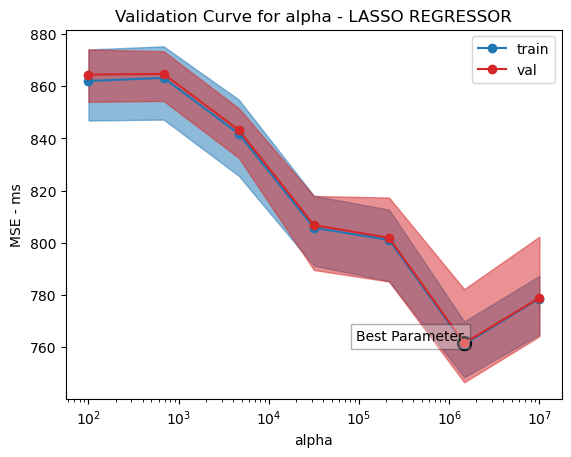

In [78]:
plt.figure()
x =  alpha_range
plt.plot(x, [info_mse_train[i][0] for i in range(len(x))],'-o', color='tab:blue', label='train')
plt.fill_between(
    x, 
    [info_mse_train[i][1] for i in range(len(x))], 
    [info_mse_train[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:blue'
)
plt.plot(x, [info_mse_val[i][0] for i in range(len(x))],'-o', color='tab:red', label='val')
plt.fill_between(
    x, 
    [info_mse_val[i][1] for i in range(len(x))], 
    [info_mse_val[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:red'
)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE - ms')
plt.title('Validation Curve for alpha - LASSO REGRESSOR')
#plt.ylim(0.7, 1.02)
plt.scatter(best_parameter, best_val_score, marker='o', color='black',s=100)
plt.text(best_parameter, best_val_score, "Best Parameter", color='black', ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.3))
#plt.xticks(x, alpha_range)
plt.legend()
plt.show()

In [69]:
best_parameter

1467799.2676220706

In [87]:
best_val_score

761.500784042

In [32]:
%%time
alpha_range = np.logspace(5, 10, 7) #18.15
# Create the Lasso; 
ls_regressor = Lasso()

# Generate validation curve using Mean Squared Error (MSE) as the scoring metric
train_scores, val_scores = validation_curve(
    ls_regressor, X, y, param_name="alpha", param_range=alpha_range,
    scoring="neg_mean_absolute_error", cv=5
)


CPU times: user 33min 21s, sys: 53min 29s, total: 1h 26min 50s
Wall time: 10min 57s


In [33]:
train_scores

array([[-806.96907831, -814.88613497, -806.09594515, -787.9953934 ,
        -797.50072887],
       [-767.61749072, -773.09095839, -769.79456496, -751.95649034,
        -759.69999464],
       [-765.21139897, -769.3987918 , -767.28708965, -749.17310208,
        -756.54005165],
       [-784.4724086 , -789.71024208, -786.20393424, -766.18080792,
        -775.46923578],
       [-784.68922964, -789.94594086, -786.6229312 , -766.34807105,
        -775.27951995],
       [-784.68922964, -789.94594086, -786.6229312 , -766.34807105,
        -775.27951995],
       [-784.68922964, -789.94594086, -786.6229312 , -766.34807105,
        -775.27951995]])

In [34]:
val_scores

array([[-801.19643954, -803.74957929, -785.41170511, -816.93111949,
        -810.6136325 ],
       [-759.95489796, -756.07085001, -748.43286712, -785.17934459,
        -775.28559297],
       [-755.30004008, -748.68978166, -749.95491713, -784.63146131,
        -770.94930433],
       [-773.51918246, -765.3993299 , -770.66474712, -803.94905311,
        -788.66238818],
       [-773.58863373, -765.67185522, -770.87276282, -804.2057783 ,
        -788.53616732],
       [-773.58863373, -765.67185522, -770.87276282, -804.2057783 ,
        -788.53616732],
       [-773.58863373, -765.67185522, -770.87276282, -804.2057783 ,
        -788.53616732]])

In [79]:
##recovering previous results

alpha_range = np.logspace(5, 10, 7)

train_scores = np.array([[-806.96907831, -814.88613497, -806.09594515, -787.9953934 ,
        -797.50072887],
       [-767.61749072, -773.09095839, -769.79456496, -751.95649034,
        -759.69999464],
       [-765.21139897, -769.3987918 , -767.28708965, -749.17310208,
        -756.54005165],
       [-784.4724086 , -789.71024208, -786.20393424, -766.18080792,
        -775.46923578],
       [-784.68922964, -789.94594086, -786.6229312 , -766.34807105,
        -775.27951995],
       [-784.68922964, -789.94594086, -786.6229312 , -766.34807105,
        -775.27951995],
       [-784.68922964, -789.94594086, -786.6229312 , -766.34807105,
        -775.27951995]])

val_scores = np.array([[-801.19643954, -803.74957929, -785.41170511, -816.93111949,
        -810.6136325 ],
       [-759.95489796, -756.07085001, -748.43286712, -785.17934459,
        -775.28559297],
       [-755.30004008, -748.68978166, -749.95491713, -784.63146131,
        -770.94930433],
       [-773.51918246, -765.3993299 , -770.66474712, -803.94905311,
        -788.66238818],
       [-773.58863373, -765.67185522, -770.87276282, -804.2057783 ,
        -788.53616732],
       [-773.58863373, -765.67185522, -770.87276282, -804.2057783 ,
        -788.53616732],
       [-773.58863373, -765.67185522, -770.87276282, -804.2057783 ,
        -788.53616732]])

In [80]:
info_mse_train = []
info_mse_val = []
best_val_score = -val_scores[0].mean()
best_parameter = -1

for n, param in enumerate(alpha_range):
    #test_scores
    mse_mean_train = -train_scores[n].mean()
    mse_min_train = -train_scores[n].min()
    mse_max_train = -train_scores[n].max()
    info_mse_train.append((mse_mean_train, mse_min_train, mse_max_train))
    #val_scores
    mse_mean_val = -val_scores[n].mean()
    mse_min_val = -val_scores[n].min()
    mse_max_val = -val_scores[n].max()
    if (mse_mean_val<best_val_score):
        best_val_score = mse_mean_val
        best_parameter = param
    info_mse_val.append((mse_mean_val, mse_min_val, mse_max_val))


info_mse_val
   



[(803.580495186, 816.93111949, 785.41170511),
 (764.9847105299999, 785.17934459, 748.43286712),
 (761.905100902, 784.63146131, 748.68978166),
 (780.438940154, 803.94905311, 765.3993299),
 (780.575039478, 804.2057783, 765.67185522),
 (780.575039478, 804.2057783, 765.67185522),
 (780.575039478, 804.2057783, 765.67185522)]

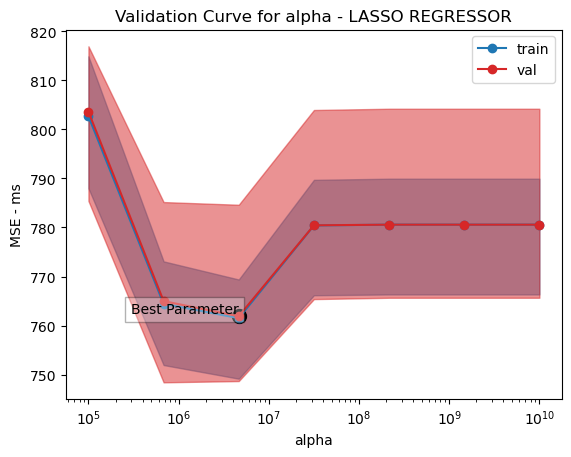

In [82]:
plt.figure()
x =  alpha_range
plt.plot(x, [info_mse_train[i][0] for i in range(len(x))],'-o', color='tab:blue', label='train')
plt.fill_between(
    x, 
    [info_mse_train[i][1] for i in range(len(x))], 
    [info_mse_train[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:blue'
)
plt.plot(x, [info_mse_val[i][0] for i in range(len(x))],'-o', color='tab:red', label='val')
plt.fill_between(
    x, 
    [info_mse_val[i][1] for i in range(len(x))], 
    [info_mse_val[i][2] for i in range(len(x))], 
    alpha=0.5, 
    color='tab:red'
)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE - ms')
plt.title('Validation Curve for alpha - LASSO REGRESSOR')
#plt.ylim(0.7, 1.02)
plt.scatter(best_parameter, best_val_score, marker='o', color='black',s=100)
plt.text(best_parameter, best_val_score, "Best Parameter", color='black', ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.3))
#plt.xticks(x, alpha_range)
plt.legend()
plt.show()

In [83]:
best_parameter

4641588.833612782

In [84]:
best_val_score

761.905100902

#### LEARNING CURVE

In [88]:
### Now we need to use the entire training dataset for learning curve 
X = df_train_copy.drop(columns = "_s_rtt_avg").to_numpy()
y = df_train_copy["_s_rtt_avg"].to_numpy()

# Standardize data
scaler = StandardScaler()
scaler.fit(X)

# X --> X_learningCurve_s
X_learningCurve_s = pd.DataFrame(scaler.transform(X), columns = features_list_copy)

In [90]:
%%time
ls = Lasso(
    ####---best parameter---###
    alpha = best_parameter
)

train_sizes, train_scores, val_scores = learning_curve(
    ls, X_learningCurve_s, y, cv=KFold(n_splits=5, shuffle=True, random_state=42),
    train_sizes=np.arange(0.1, 1.0, 0.1), scoring="neg_mean_absolute_error"
)

CPU times: user 41.1 s, sys: 1min 29s, total: 2min 10s
Wall time: 18.6 s


In [94]:
train_sizes

array([ 11826,  23653,  35479,  47306,  59132,  70959,  82785,  94612,
       106438])

In [95]:
train_scores

array([[-2238.83819416, -2229.95706545, -2235.16291186, -2190.3495982 ,
        -2295.64631423],
       [-1888.04718607, -1893.46621139, -1866.6184722 , -1874.58859498,
        -1926.44707308],
       [-1701.06189041, -1722.17451971, -1683.58851906, -1673.72363201,
        -1738.53820134],
       [-1638.02177835, -1670.65181634, -1617.40215394, -1609.78681112,
        -1673.03156553],
       [-1468.84353669, -1498.41608524, -1464.9445454 , -1453.88361786,
        -1515.08572784],
       [-1240.29298722, -1265.42684209, -1237.06252206, -1227.78127078,
        -1279.40251024],
       [-1074.52265499, -1096.33890668, -1072.02165234, -1064.01402961,
        -1108.62724773],
       [ -947.95806154,  -966.97945423,  -945.67442499,  -938.57698873,
         -977.98674323],
       [ -848.79051361,  -865.52604709,  -846.45804474,  -840.17744064,
         -875.54827776]])

In [96]:
val_scores

array([[-1558.51213991, -1515.81410832, -1554.89743456, -1542.70405083,
        -1538.24524145],
       [-1374.66034221, -1341.89088851, -1364.71592453, -1379.30498326,
        -1344.05507178],
       [-1275.7107482 , -1252.18040533, -1268.65556345, -1273.75094422,
        -1243.18075455],
       [-1244.70963442, -1227.77926658, -1235.97868196, -1242.7020437 ,
        -1211.21927928],
       [-1151.68365429, -1133.11278058, -1152.06988177, -1157.0016321 ,
        -1124.06695687],
       [-1028.00498835, -1007.52680642, -1029.4640445 , -1035.62295627,
         -996.64970164],
       [ -941.06951529,  -919.0405934 ,  -943.3568674 ,  -950.24552933,
         -907.08822029],
       [ -875.38088069,  -852.10508875,  -878.0353957 ,  -885.59450792,
         -839.36874011],
       [ -824.72122532,  -800.44968359,  -827.47268734,  -835.71588456,
         -787.07530398]])

In [97]:
info_mae_train = []
info_mae_val = []

best_val_score = 1e20
best_proportion = 0

for n, train_proportion in enumerate(np.arange(0.1, 1.0, 0.1)): 
    #test_scores
    mae_mean_train = -train_scores[n].mean()
    mae_min_train = -train_scores[n].min()
    mae_max_train = -train_scores[n].max()
    info_mae_train.append((mae_mean_train, mae_min_train, mae_max_train))
    #val_scores
    mae_mean_val = -val_scores[n].mean()
    mae_min_val = -val_scores[n].min()
    mae_max_val = -val_scores[n].max()
    if (mae_mean_val<best_val_score):
        best_val_score = mae_mean_val
        best_proportion = train_proportion
    info_mae_val.append((mae_mean_val, mae_min_val, mae_max_val))


info_mae_val = np.array(info_mae_val)/1000
info_mae_train = np.array(info_mae_train)/1000
info_mae_val

array([[1.5420346 , 1.55851214, 1.51581411],
       [1.36092544, 1.37930498, 1.34189089],
       [1.26269568, 1.27571075, 1.24318075],
       [1.23247778, 1.24470963, 1.21121928],
       [1.14358698, 1.15700163, 1.12406696],
       [1.0194537 , 1.03562296, 0.9966497 ],
       [0.93216015, 0.95024553, 0.90708822],
       [0.86609692, 0.88559451, 0.83936874],
       [0.81508696, 0.83571588, 0.7870753 ]])

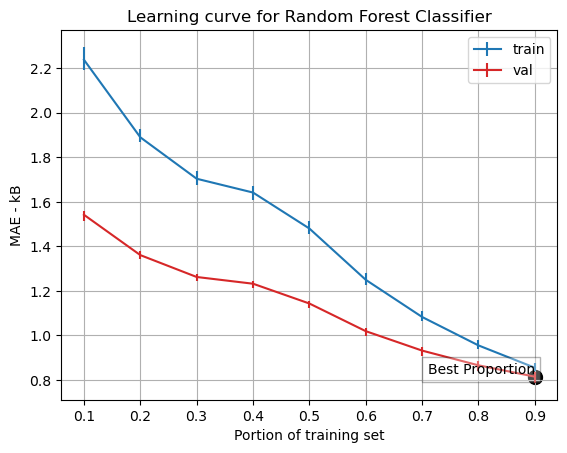

In [98]:
plt.figure()

plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info_mae_train[i][0] for i in range(len(info_mae_train))], # y-location of each error bar
    # the size of each error bar
    yerr = [
        [info_mae_train[i][0]-info_mae_train[i][1] for i in range(len(info_mae_train))], 
        [info_mae_train[i][2]-info_mae_train[i][0] for i in range(len(info_mae_train))]
    ],
    color='tab:blue',
    label='train'
)

plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info_mae_val[i][0] for i in range(len(info_mae_val))], # y-location of each error bar
    # the size of each error bar
    yerr = [
        [info_mae_val[i][0]-info_mae_val[i][1] for i in range(len(info_mae_val))], 
        [info_mae_val[i][2]-info_mae_val[i][0] for i in range(len(info_mae_val))]
    ],
    color='tab:red',
    label='val'
)
plt.grid()
plt.xlabel('Portion of training set')
plt.ylabel('MAE - kB')
plt.title("Learning curve for Random Forest Classifier")
plt.xticks(np.arange(0.1, 1.0, 0.1), labels = np.arange(0.1, 1.0, 0.1).round(1))
plt.scatter(best_proportion, best_val_score/1000, marker='o', color='black',s=100)
plt.text(best_proportion, best_val_score/1000, "Best Proportion", color='black', ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.3))
#plt.ylim(0.75, 1.02)
plt.legend()
plt.show()

# Test best model on unseen data

In [86]:
best_proportion

0.9

In [88]:
### Data Preprocessing - ELIMINATION OF HIGHLY CORRELATED FEATURES!!!

X = df_train_copy.drop(columns = "_s_rtt_avg").to_numpy()
y = df_train_copy["_s_rtt_avg"].to_numpy()

X_test = df_test_copy.drop(columns = "_s_rtt_avg").to_numpy()
y_test = df_test_copy["_s_rtt_avg"].to_numpy()

# splitting training set 
X, X_val, y, y_val = train_test_split( # X -> features, y -> labels
    X, # X
    y, # y
    #stratify = df_training['numerical_label'], # no need of stratification
    train_size = best_proportion, # percentage of training set
    random_state = 15 
)

# Standardize data
scaler = StandardScaler()
scaler.fit(X)

X_s = pd.DataFrame(scaler.transform(X), columns = features_list_copy)
X_val_s = pd.DataFrame(scaler.transform(X_val), columns = features_list_copy)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns = features_list_copy)

correlation_matrix = X_s.corr().abs()

def correlated_features_to_remove(correlation_matrix):
    to_delete = []
    for i, f1 in enumerate(correlation_matrix):
        for j, f2 in enumerate(correlation_matrix) :
            if (i!=j and correlation_matrix.iloc[i, j]>0.8 and (f2 not in to_delete)):
                to_delete.append(f1)
                break
    return to_delete

to_delete = correlated_features_to_remove(correlation_matrix)

print(len(to_delete), 'features are removed')

# X_s.drop(columns = to_delete, inplace = True)
# X_test_s.drop(columns = to_delete, inplace = True)
# X_final_test_s.drop(columns = to_delete, inplace = True)

41 features are removed


In [102]:
%%time
# Refer to LASSO regressor 
# by training scikit-learn models with default configuration.

#fit the models
lasso_regressor = Lasso(alpha = best_parameter)

lasso_regressor.fit(X_s, y)

#predictions on training and test sets
predictions_train = lasso_regressor.predict(X_s)
predictions_val = lasso_regressor.predict(X_val_s)
predictions_test = lasso_regressor.predict(X_test_s)

CPU times: user 1.77 s, sys: 2.96 s, total: 4.72 s
Wall time: 712 ms


In [103]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error

### --- mean_squared_error --- ###
MSE_lassoRegression_train = mean_squared_error(predictions_train, y)
MSE_lassoRegression_val = mean_squared_error(predictions_val, y_val)
MSE_lassoRegression_test = mean_squared_error(predictions_test, y_test)


### --- mean_absolute_error --- ###
MAE_lassoRegression_train = mean_absolute_error(predictions_train, y)
MAE_lassoRegression_val = mean_absolute_error(predictions_val, y_val)
MAE_lassoRegression_test = mean_absolute_error(predictions_test, y_test)


### --- print the results --- ###
print("LASSO REGRESSOR EVALUATION:")
print("\tTRAIN SET")
#print("\t\tMEAN SQUARED ERROR = %.2f" %(MSE_lassoRegression_train))
print("\t\tMEAN ABSOLUTE ERROR = %.2f" %(MAE_lassoRegression_train))
print("\tVAL SET")
#print("\t\tMEAN SQUARED ERROR = %.2f" %(MSE_lassoRegression_test))
print("\t\tMEAN ABSOLUTE ERROR = %.2f" %(MAE_lassoRegression_val))
print("\tTEST SET")
#print("\t\tMEAN SQUARED ERROR = %.2f" %(MSE_lassoRegression_test))
print("\t\tMEAN ABSOLUTE ERROR = %.2f" %(MAE_lassoRegression_test))


LASSO REGRESSOR EVALUATION:
	TRAIN SET
		MEAN ABSOLUTE ERROR = 780.58
	VAL SET
		MEAN ABSOLUTE ERROR = 769.07
	TEST SET
		MEAN ABSOLUTE ERROR = 852.13
